In [31]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from src.load_data import dataset
from src.decorator import add_print

In [32]:
# データセットの読み込み
DATASET = dataset()
print(DATASET["fashion-mnist"][1].shape)

c:\Users\human\OneDrive - 埼玉大学\学部4年\04_後期授業\機械学習特論\python\env\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
c:\Users\human\OneDrive - 埼玉大学\学部4年\04_後期授業\機械学習特論\python\env\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(7000, 10)


### CNNのハイパーパラメータ
- Dropout
- Conv & MaxPool の数 (2 or 3)
- Filter数
- kernel_size (3 or 5)

In [33]:
# CNNのチューニング用関数
def cnn_bulder(hp: kt.HyperParameters) -> tf.keras.Model:
    
    hp_filters = hp.Int("num_filter", min_value=16, max_value=129, step=16)
    hp_kernel_size = hp.Choice("kernel_size", values=[3, 5])
    hp_rate = hp.Choice("dropout_rate", values=[0.0, 0.1, 0.2])
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(hp_filters, kernel_size=hp_kernel_size, activation="relu", input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # tf.keras.layers.Conv2D(hp_filters, kernel_size=hp_kernel_size, activation="relu"),
        # tf.keras.layers.MaxPooling2D((2, 2)),
        # tf.keras.layers.Conv2D(hp_filters, kernel_size=hp_kernel_size, activation="relu"),
        tf.keras.layers.Dropout(hp_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    

    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
    
    return model

## Fasion-MNIST
### MLP

In [34]:
dataname = "fashion-mnist"
ds_x, ds_y = DATASET[dataname]
train_x, test_x, train_y, test_y = train_test_split(ds_x, ds_y, test_size=0.25, random_state=1, stratify=ds_y)

In [35]:
tf.random.set_seed(42)

# 学習
mlp_tuner = kt.Hyperband(
    cnn_bulder,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="C://Users/human/Downloads",
    project_name="fashion_cnn3"
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mlp_tuner.search(train_x, train_y, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.8571428656578064

Best val_accuracy So Far: 0.8819047808647156
Total elapsed time: 00h 06m 15s


## ベストパラメータメモ
**Filter & Kernel** (path: fashion_tuner(`C://users/human/Downloads/fashion_tuner`))

| params | value |
| -- | -- |
| Num Filter | 128 |
| Kernel size | 3 |
| Train (50 epochs) | 5m 39.8s |
| Test accuracy | 0.8451428571428572 |

**Filter & Kernel & Dropout** (path: fashion_cnn2(`C://users/human/Downloads/fashion_cnn2`))

| params | value |
| -- | -- |
| Num Filter |  |
| Kernel size |  |
| Dropout rate |  |
| Train (20 epochs) | Xm Xs |

In [36]:
best_hps = mlp_tuner.get_best_hyperparameters(num_trials=1)[0]

@add_print()
def print_best_hps():
    print("Num filter:", best_hps.get("num_filter"))
    print("Kernel size:", best_hps.get("kernel_size"))
    print("Dropout rate:", best_hps.get("dropout_rate"))
print_best_hps()



Num filter: 80
Kernel size: 3
Dropout rate: 0.1




#### チューニング結果からモデルを作成

In [37]:
# ベストエポックを保存
checkpoint_filepath = "C://Users/human/Downloads/fashion_cnn2_checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

best_mlp_model = mlp_tuner.hypermodel.build(best_hps)
mlp_history = best_mlp_model.fit(train_x, train_y, epochs=20, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/20
129/132 [============================>.] - ETA: 0s - loss: 0.8097 - accuracy: 0.7125INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 5s 33ms/step - loss: 0.8064 - accuracy: 0.7138 - val_loss: 0.5565 - val_accuracy: 0.8010
Epoch 2/20
131/132 [============================>.] - ETA: 0s - loss: 0.5034 - accuracy: 0.8161INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 30ms/step - loss: 0.5027 - accuracy: 0.8164 - val_loss: 0.4960 - val_accuracy: 0.8267
Epoch 3/20
129/132 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8551INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 28ms/step - loss: 0.4153 - accuracy: 0.8560 - val_loss: 0.4489 - val_accuracy: 0.8333
Epoch 4/20
129/132 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8748INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 28ms/step - loss: 0.3614 - accuracy: 0.8755 - val_loss: 0.4488 - val_accuracy: 0.8371
Epoch 5/20
131/132 [============================>.] - ETA: 0s - loss: 0.3272 - accuracy: 0.8824INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 28ms/step - loss: 0.3270 - accuracy: 0.8824 - val_loss: 0.4051 - val_accuracy: 0.8581
Epoch 6/20
132/132 [==============================] - 3s 25ms/step - loss: 0.2967 - accuracy: 0.8976 - val_loss: 0.4080 - val_accuracy: 0.8581
Epoch 7/20
132/132 [==============================] - 3s 25ms/step - loss: 0.2657 - accuracy: 0.9088 - val_loss: 0.3942 - val_accuracy: 0.8571
Epoch 8/20
132/132 [==============================] - 4s 27ms/step - loss: 0.2420 - accuracy: 0.9152 - val_loss: 0.4024 - val_accuracy: 0.8476
Epoch 9/20
130/132 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9260INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 29ms/step - loss: 0.2259 - accuracy: 0.9257 - val_loss: 0.3903 - val_accuracy: 0.8619
Epoch 10/20
131/132 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9323INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 29ms/step - loss: 0.2053 - accuracy: 0.9324 - val_loss: 0.3925 - val_accuracy: 0.8705
Epoch 11/20
132/132 [==============================] - 3s 25ms/step - loss: 0.1891 - accuracy: 0.9352 - val_loss: 0.4014 - val_accuracy: 0.8638
Epoch 12/20
132/132 [==============================] - 3s 26ms/step - loss: 0.1771 - accuracy: 0.9412 - val_loss: 0.3971 - val_accuracy: 0.8638
Epoch 13/20
131/132 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9461INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\fashion_cnn2_checkpoint/assets


132/132 [==============================] - 4s 28ms/step - loss: 0.1675 - accuracy: 0.9462 - val_loss: 0.3879 - val_accuracy: 0.8733
Epoch 14/20
132/132 [==============================] - 3s 25ms/step - loss: 0.1569 - accuracy: 0.9507 - val_loss: 0.4195 - val_accuracy: 0.8552
Epoch 15/20
132/132 [==============================] - 3s 24ms/step - loss: 0.1431 - accuracy: 0.9533 - val_loss: 0.4496 - val_accuracy: 0.8600
Epoch 16/20
132/132 [==============================] - 3s 25ms/step - loss: 0.1333 - accuracy: 0.9581 - val_loss: 0.4223 - val_accuracy: 0.8629
Epoch 17/20
132/132 [==============================] - 3s 26ms/step - loss: 0.1240 - accuracy: 0.9605 - val_loss: 0.4216 - val_accuracy: 0.8724
Epoch 18/20
132/132 [==============================] - 3s 26ms/step - loss: 0.1106 - accuracy: 0.9667 - val_loss: 0.4270 - val_accuracy: 0.8705
Epoch 19/20
132/132 [==============================] - 3s 25ms/step - loss: 0.1136 - accuracy: 0.9652 - val_loss: 0.4495 - val_accuracy: 0.8590
Epoc

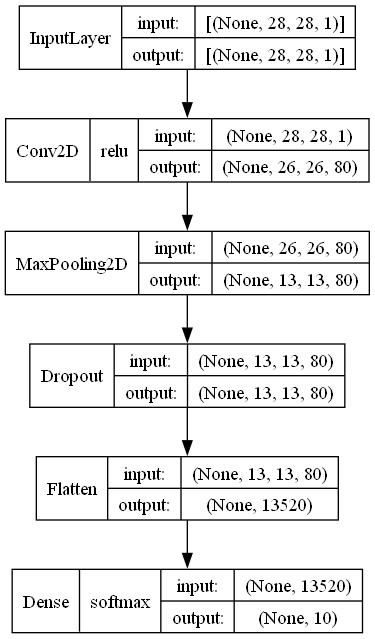

In [38]:
# モデルを描画
tf.keras.utils.plot_model(
    best_mlp_model, 
    show_shapes=True, 
    show_layer_names=False, 
    show_layer_activations=True
)

In [39]:
best_epoch_model = tf.keras.models.load_model(checkpoint_filepath)
best_epoch_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 80)        800       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 80)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 80)        0         
                                                                 
 flatten_1 (Flatten)         (None, 13520)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                135210    
                                                                 
Total params: 136010 (531.29 KB)
Trainable params: 136010 (531.29 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [40]:
pred_y = best_epoch_model.predict(test_x)
pred_y = np.round(pred_y).astype(int)

@add_print("~", 20)
def print_accuracy():
    print("Test accuracy:", accuracy_score(pred_y, test_y))
print_accuracy()

55/55 [==============================] - 0s 6ms/step

~~~~~~~~~~~~~~~~~~~~

Test accuracy: 0.8502857142857143

~~~~~~~~~~~~~~~~~~~~

